In [ ]:
import librosa as l
import numpy as np
from numpy.ma.core import asarray
import pandas as pd
import re
import os
from glob import glob
from tqdm import tqdm
import itertools
from pomegranate import *
from copy import copy
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import warnings
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
from torch import optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

warnings.simplefilter(action='ignore', category=FutureWarning)

In [85]:
# Define useful variables

digits_dir = "./pr_lab2_2020-21_data/digits/"
n_samples = 133

# Dictionary to convert string digits in their numerical format.
str2num = {'one':1, 'two':2, 'three':3, 'four':4, 'five':5, 'six':6, 'seven':7, 'eight':8, 'nine':9}
# Dictionary to convert digits from numerical format to their string representation.
num2str = {v: k for k, v in str2num.items()}

In [44]:
def data_parser(digits_dir, n_samples, str2num):
    """ 
    Args: digits_dir: a string which contains the directory of the data.
          str2num: a dictionary that converts digits from numerical format to their
                   string representation.
    Returns: wav: A list of np.arrays. Each array results from the librosa loading for each wav file
                  of the data. 
             speaker: A list of strings, each corresponding to the speaker of the respective digit.
             digit: A list of strings. Each string represents the number of the corresponding digit.
             
    This function uses the os.listdir method to read the data. For every filename, by calling the 
    librosa.load method we load it as an array, which is added to the wav list. In order to 
    distinguish the speaker and the digit that are both into the name of the file, we 
    use the method re.split() that splits a given string into a list of strings, given a character 
    to look for. This is realized with the help of digit_split method. After splitting, we guide each
    element of the list to the corresponding list. 
    """
    wav = [None] * n_samples
    speaker = np.zeros(n_samples, dtype=int)
    digit = np.zeros(n_samples, dtype=int)
    
    def digit_split(s):
        # Simple parser that splits a string in the first digit
        return re.split(r'(\d+)', s)[:2]
    
    for i, file in enumerate(os.listdir(digits_dir)):
        filename = os.fsdecode(file)
        # Read wav file with librosa
        wav[i],_ = l.load(os.path.join(digits_dir, filename), sr=16000)
        # Keep speaker and digit
        decoded_name = digit_split(filename.split('.')[0])
        if decoded_name[0] in str2num:
            digit[i] = str2num[decoded_name[0]]
        else:
            print("Error in decoding " + str(decoded_name[0]))
        speaker[i] = int(decoded_name[1])
    return wav, speaker, digit

In [45]:
wav, speaker, digit = data_parser(digits_dir, n_samples, str2num)

In [52]:
def extract_mel(wav):
    """Args: wav: A list of np.arrays. Each array results from the librosa loading for each wav file
                  of the data. 
       Returns: window_width: int. The width of the window to be used from the mfcc method.
                hop_length: int. The length of each hop, to be used from the mfcc method.
                mfccs: A list of 13x75 np.arrays resulting from the application of mfcc to each wav file.
                mfcc_deltas: A list of 13x75 np.arrays resulting from the application of feature delta
                             to the calculated mfcc array. 
                mfcc_delta2s: A list of 13x75 np.arrays resulting from the application of feature delta
                             of second order to the calculated mfcc array.
                  
    """
    window_width = 0.025
    hop_length = 0.01
    mfccs=[]
    mfcc_deltas=[]
    mfcc_delta2s=[]

    for w in wav:
        mfcc = l.feature.mfcc(w, sr=16000, n_mfcc=13, hop_length=int(sample_rate*hop_length), win_length=int(sample_rate*window_width))
        mfccs.append(mfcc)
        mfcc_deltas.append(l.feature.delta(mfcc))
        mfcc_delta2s.append(l.feature.delta(mfcc, order=2))
    return window_width, hop_length, mfccs, mfcc_deltas, mfcc_delta2s

In [54]:
window_width, hop_length, mfccs, mfcc_deltas, mfcc_delta2s = extract_mel(wav)

In [55]:
#for digit n1 = 4
n1 = 4
mfcc_1n_1 = [mfccs[i][0] for i in range(n_samples) if digit[i] == n1]
mfcc_2n_1 = [mfccs[i][1] for i in range(n_samples) if digit[i] == n1]

#for digit n2 = 9
n2 = 9
mfcc_1n_2 = [mfccs[i][0] for i in range(n_samples) if digit[i] == n2]
mfcc_2n_2 = [mfccs[i][1] for i in range(n_samples) if digit[i] == n2]

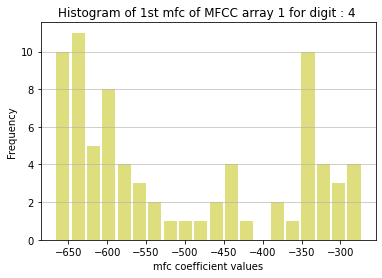

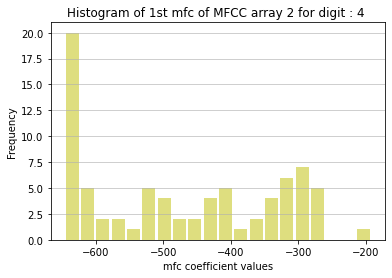

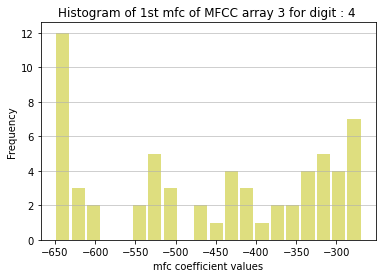

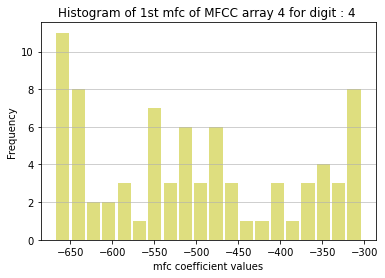

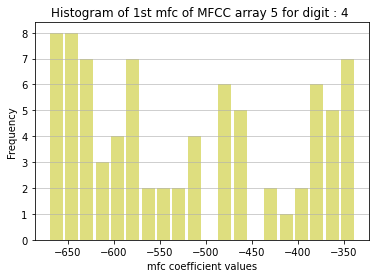

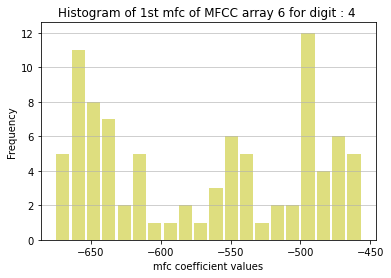

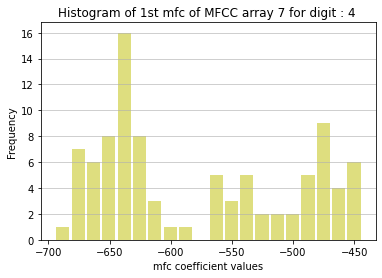

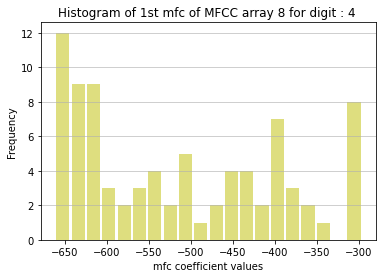

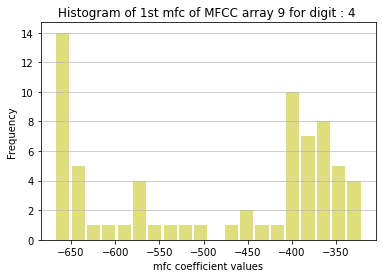

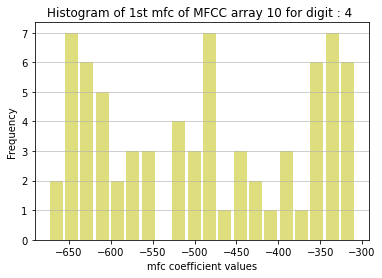

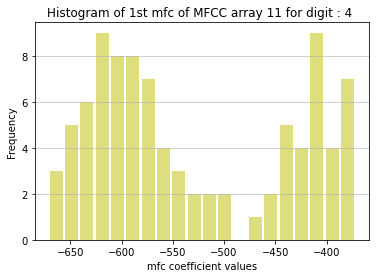

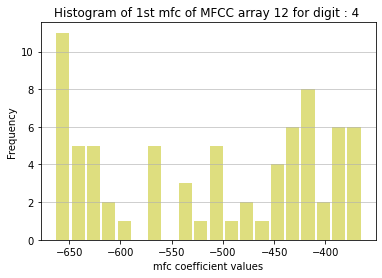

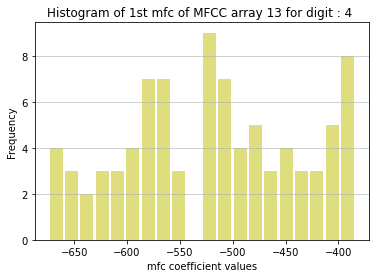

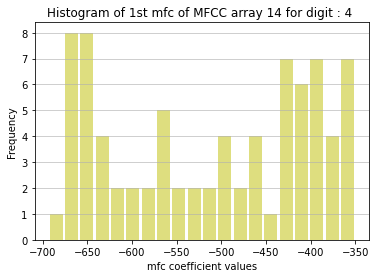

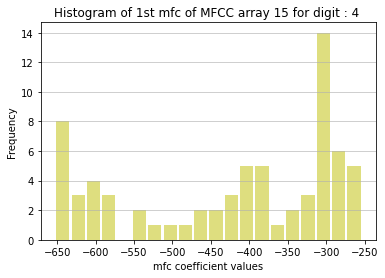

In [56]:
i=0
for d in mfcc_1n_1:
    i+=1
    plt.figure()
    n, bins, patches = plt.hist(d, bins=20, color='y', alpha=0.5, rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('mfc coefficient values')
    plt.ylabel('Frequency')
    plt.title('Histogram of 1st mfc of MFCC array ' +str(i) + ' for digit : 4 ')
    plt.show()

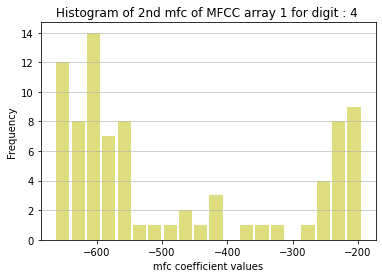

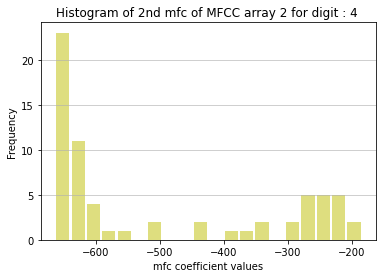

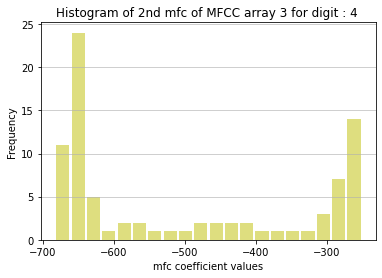

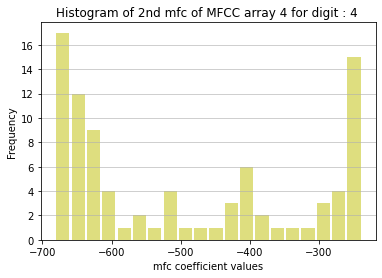

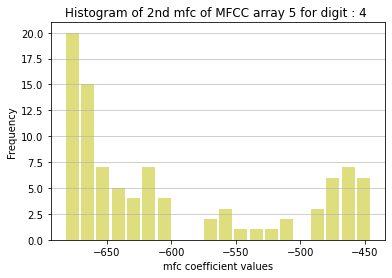

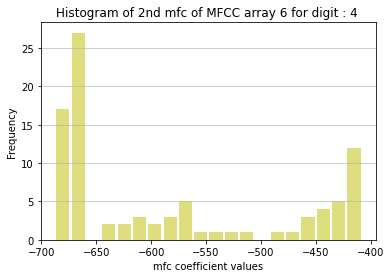

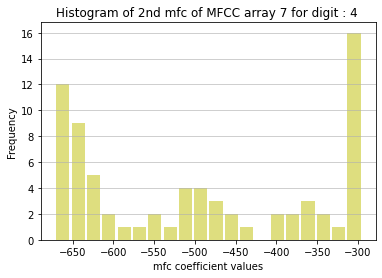

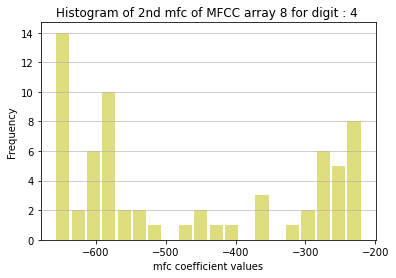

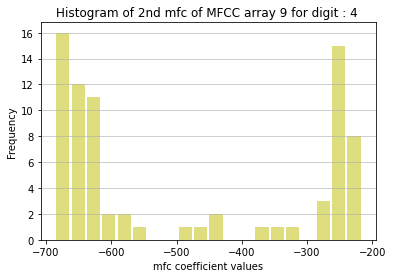

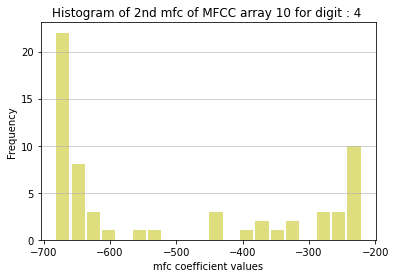

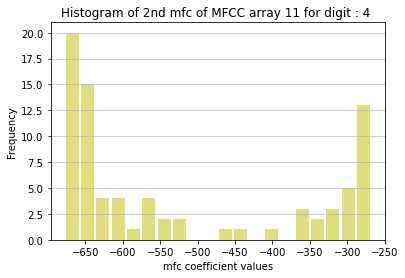

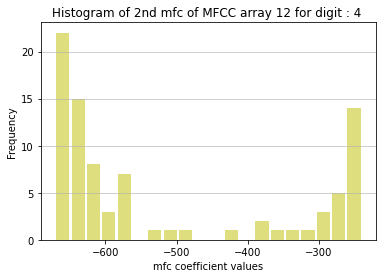

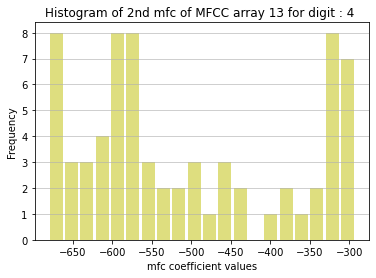

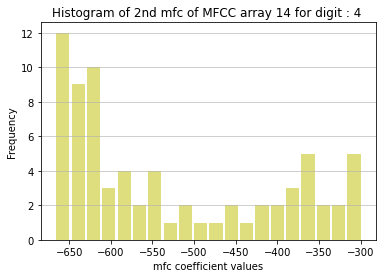

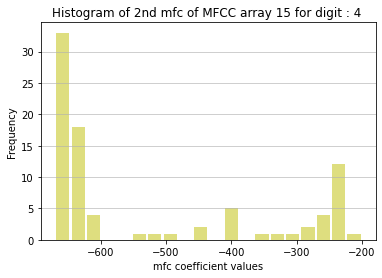

In [57]:
i=0
for d in mfcc_1n_2:
    i+=1
    plt.figure()
    n, bins, patches = plt.hist(d, bins=20, color='y', alpha=0.5, rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('mfc coefficient values')
    plt.ylabel('Frequency')
    plt.title('Histogram of 2nd mfc of MFCC array ' +str(i) + ' for digit : 4 ')
    plt.show()

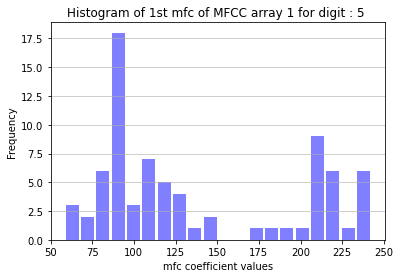

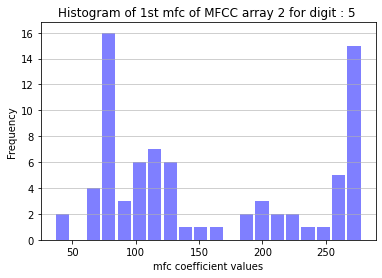

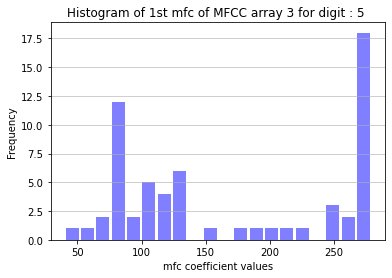

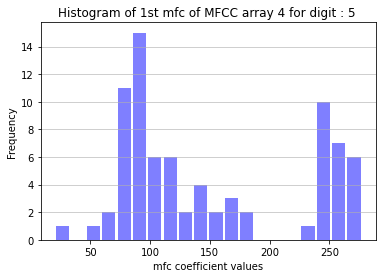

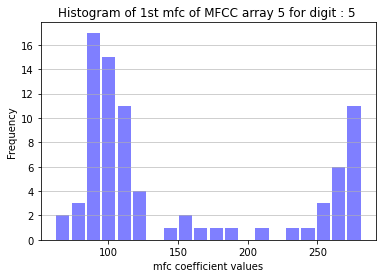

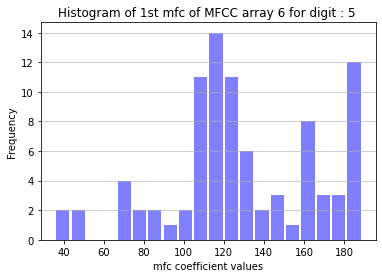

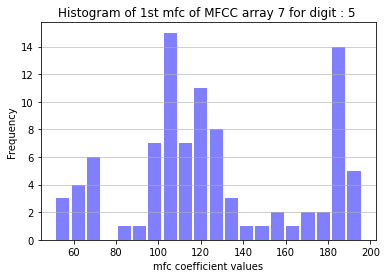

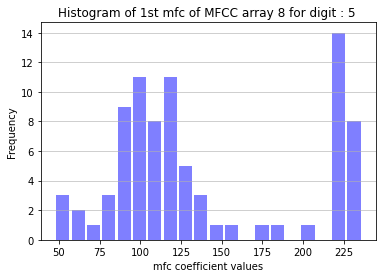

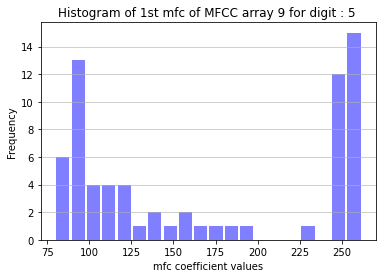

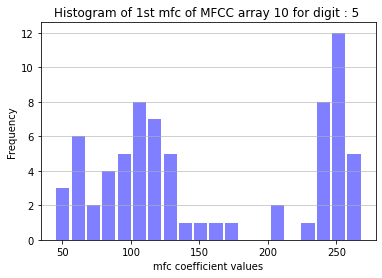

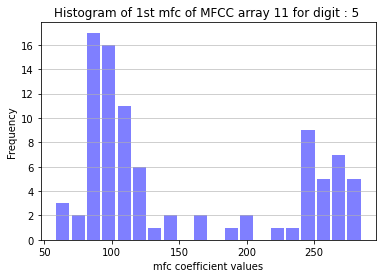

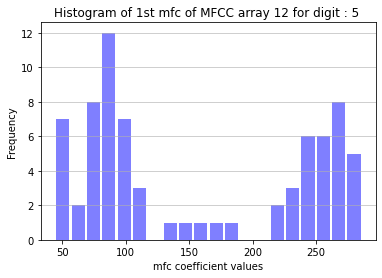

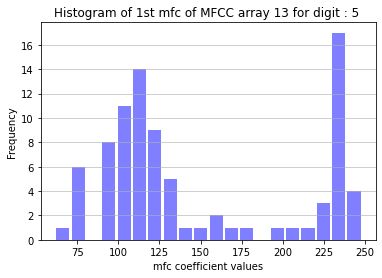

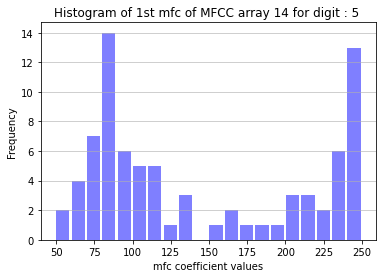

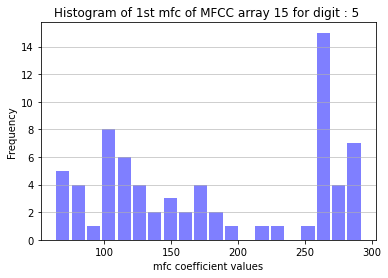

In [58]:
i=0
for d in mfcc_2n_1:
    i+=1
    plt.figure()
    n, bins, patches = plt.hist(d, bins=20, color='b', alpha=0.5, rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('mfc coefficient values')
    plt.ylabel('Frequency')
    plt.title('Histogram of 1st mfc of MFCC array ' +str(i) + ' for digit : 5 ')
    plt.show()

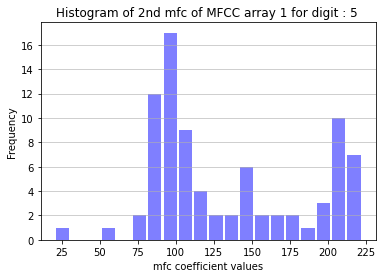

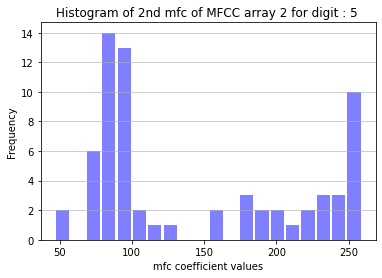

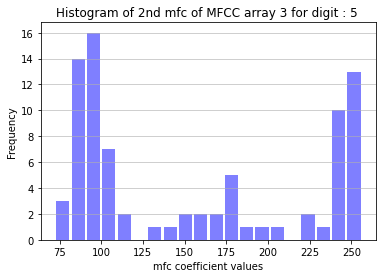

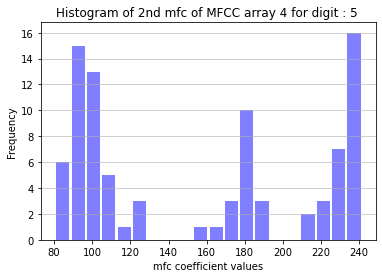

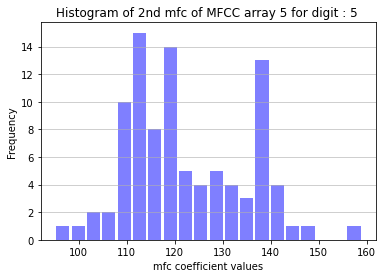

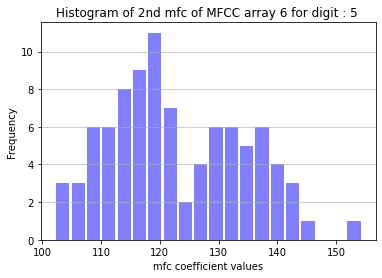

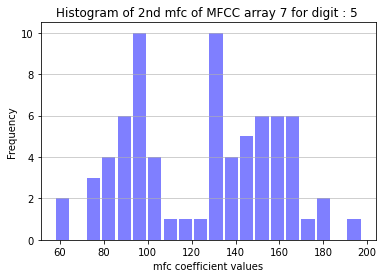

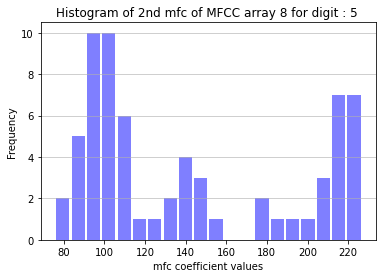

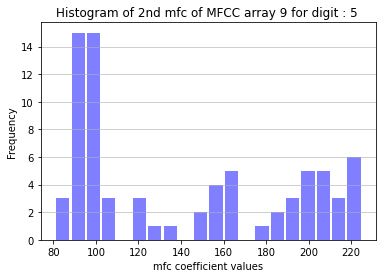

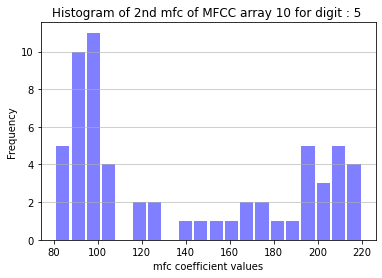

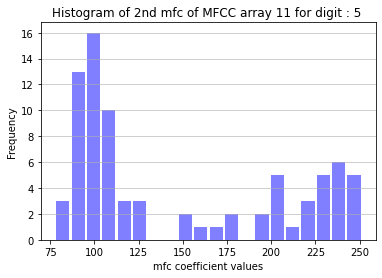

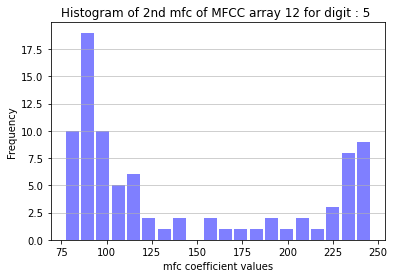

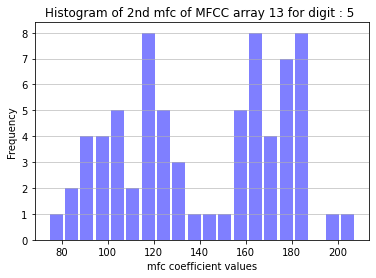

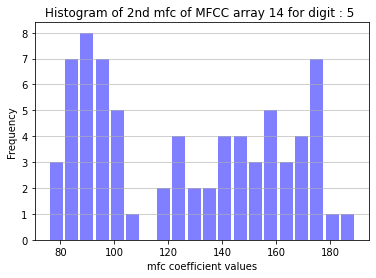

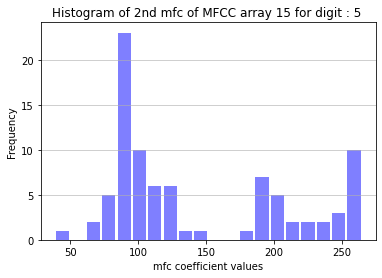

In [59]:
i=0
for d in mfcc_2n_2:
    i+=1
    plt.figure()
    n, bins, patches = plt.hist(d, bins=20, color='b', alpha=0.5, rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('mfc coefficient values')
    plt.ylabel('Frequency')
    plt.title('Histogram of 2nd mfc of MFCC array ' +str(i) + ' for digit : 5 ')
    plt.show()

In [64]:
def two_speakers(n_samples, speaker, digit, print_res=False):
    """ """
    speaker1 = 1
    speaker2 = 2
    for i in range(n_samples):
        if int(speaker[i]) == speaker1 and digit[i]== n1:
            s1_n1 = i
        if int(speaker[i]) == speaker1 and digit[i]== n2:
            s1_n2 = i
        if int(speaker[i]) == speaker2 and digit[i]== n1:
            s2_n1 = i
        if int(speaker[i]) == speaker2 and digit[i]== n2:
            s2_n2 = i
    if print_res:
        print('Speaker ' + str(speaker1) + ' for digit ' + str(n1) + ': ', s1_n1)
        print('Speaker ' + str(speaker1) + ' for digit ' + str(n2) + ': ', s1_n2)
        print('Speaker ' + str(speaker2) + ' for digit ' + str(n1) + ': ', s1_n1)
        print('Speaker ' + str(speaker2) + ' for digit ' + str(n2) + ': ', s1_n2)
    return speaker1, speaker2, s1_n1, s1_n2, s2_n1, s2_n2

def show_spectrogram(hop_length, n_samples, speaker, digit):
    """ """
    speaker1, speaker2, s1_n1, s1_n2, s2_n1, s2_n2 = two_speakers(n_samples, speaker, digit, print_res=True)
    mfscs_1_1 = l.feature.melspectrogram(wav[s1_n1], sr=16000, hop_length=int(sample_rate*hop_length), win_length=int(sample_rate*window_width), n_mels=13)
    mfscs_1_2 = l.feature.melspectrogram(wav[s1_n2], sr=16000, hop_length=int(sample_rate*hop_length), win_length=int(sample_rate*window_width), n_mels=13)
    mfscs_2_1 = l.feature.melspectrogram(wav[s2_n1], sr=16000, hop_length=int(sample_rate*hop_length), win_length=int(sample_rate*window_width), n_mels=13)
    mfscs_2_2 = l.feature.melspectrogram(wav[s2_n2], sr=16000, hop_length=int(sample_rate*hop_length), win_length=int(sample_rate*window_width), n_mels=13)

    fig = plt.figure(figsize=(20,10))

    fig.add_subplot(2, 2, 1)
    mfsc_df_1_1 = pd.DataFrame.from_records(mfscs_1_1.T)
    plt.imshow(mfsc_df_1_1.corr())
    plt.colorbar()
    plt.title('Correlation matrix for mfsc transformation of digit ' +str(n1) + ' pronounced by speaker ' + str(speaker1))


    fig.add_subplot(2, 2, 2)
    mfsc_df_1_2 = pd.DataFrame.from_records(mfscs_1_2.T)
    plt.imshow(mfsc_df_1_2.corr())
    plt.colorbar()
    plt.title('Correlation matrix for mfsc transformation of digit ' +str(n2) + ' pronounced by speaker ' + str(speaker1))

    fig.add_subplot(2, 2, 3)
    mfsc_df_2_1 = pd.DataFrame.from_records(mfscs_2_1.T)
    plt.imshow(mfsc_df_2_1.corr())
    plt.colorbar()
    plt.title('Correlation matrix for mfsc transformation of digit ' +str(n1) + ' pronounced by speaker ' + str(speaker2))

    fig.add_subplot(2, 2, 4)
    mfsc_df_2_2 = pd.DataFrame.from_records(mfscs_2_2.T)
    plt.imshow(mfsc_df_2_2.corr())
    plt.colorbar()
    plt.title('Correlation matrix for mfsc transformation of digit ' +str(n2) + ' pronounced by speaker ' + str(speaker2))

    plt.show()
    
    fig = plt.figure(figsize=(20,10))

    fig.add_subplot(2, 2, 1)
    mfcc_df_1_1 = pd.DataFrame.from_records(mfccs[s1_n1].T)
    plt.imshow(mfcc_df_1_1.corr())
    plt.colorbar()
    plt.title('Correlation matrix for mfcc transformation of digit ' +str(n1) + ' pronounced by speaker ' + str(speaker1))

    fig.add_subplot(2, 2, 2)
    mfcc_df_1_2 = pd.DataFrame.from_records(mfccs[s1_n2].T)
    plt.imshow(mfcc_df_1_2.corr())
    plt.colorbar()
    plt.title('Correlation matrix for mfcc transformation of digit ' +str(n2) + ' pronounced by speaker ' + str(speaker1))

    fig.add_subplot(2, 2, 3)
    mfcc_df_2_1 = pd.DataFrame.from_records(mfccs[s2_n1].T)
    plt.imshow(mfcc_df_2_1.corr())
    plt.colorbar()
    plt.title('Correlation matrix for mfcc transformation of digit ' +str(n1) + ' pronounced by speaker ' + str(speaker2))

    fig.add_subplot(2, 2, 4)
    mfcc_df_2_2 = pd.DataFrame.from_records(mfccs[s2_n2].T)
    plt.imshow(mfcc_df_2_2.corr())
    plt.colorbar()
    plt.title('Correlation matrix for mfcc transformation of digit ' +str(n2) + ' pronounced by speaker ' + str(speaker2))

    plt.show()

Speaker 1 for digit 4:  29
Speaker 1 for digit 9:  44
Speaker 2 for digit 4:  29
Speaker 2 for digit 9:  44


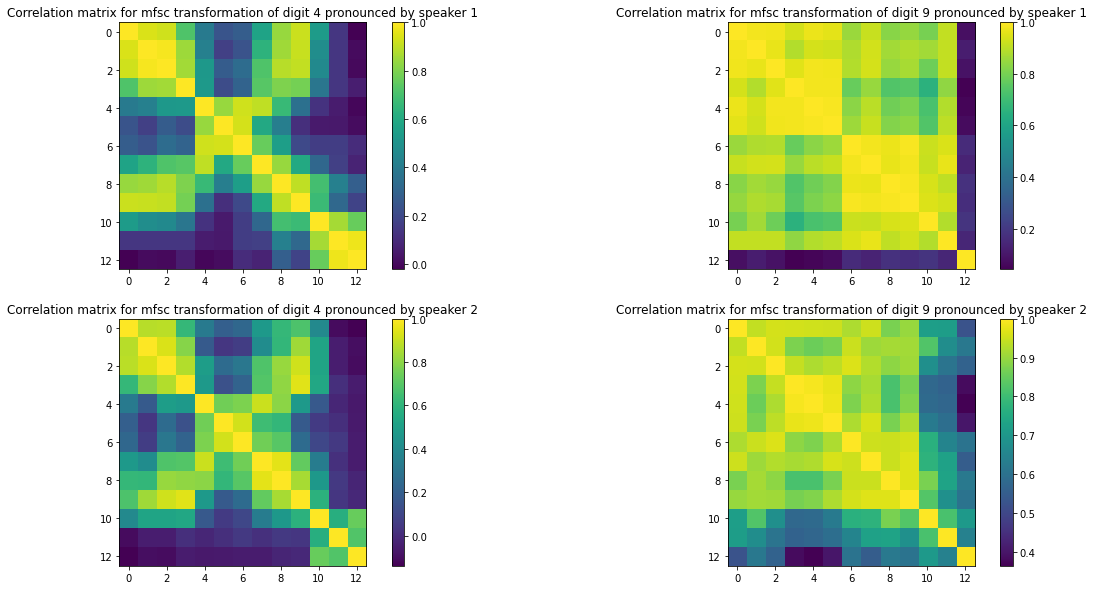

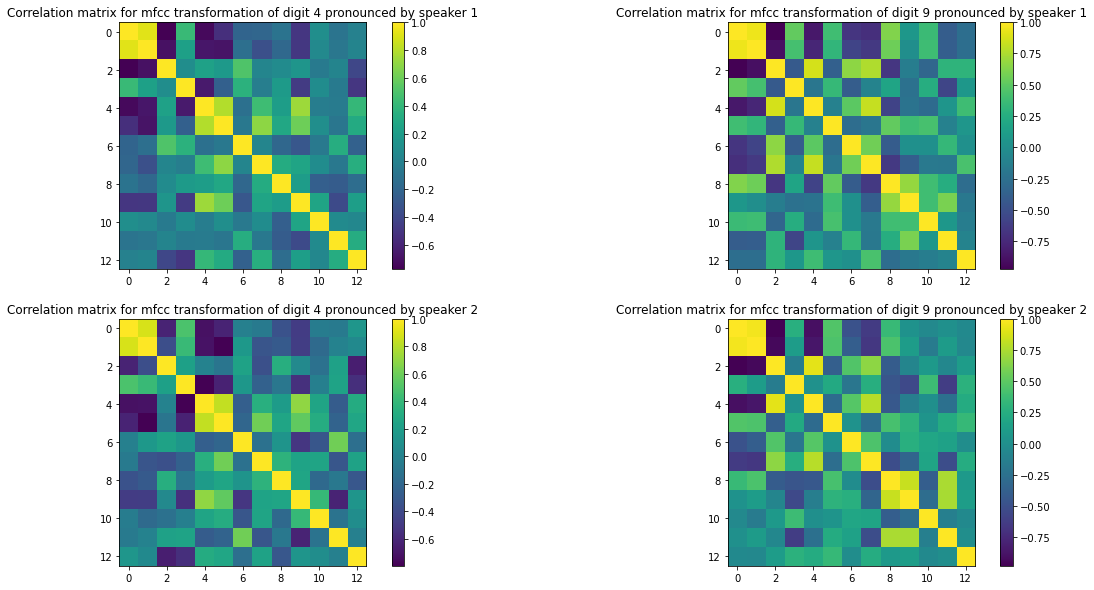

In [65]:
show_spectrogram(hop_length, n_samples, speaker, digit)

In [67]:
def get_vector(mfccs, mfcc_deltas, mfcc_delta2s):
    """ 
    Args: mfcc: A list of arrays. It is the result of the application of the method librosa.fatures.mfcc
          deltas: A list of arrays. It is the result of the application of the method librosa.features.delta
          deltas_2: A list of arrays. It is the result of the application of the method librosa.fatures.delta
    Returns: vec: list of lists, containing the mean value and standard deviation for every row of all input arrays. 
    
    This function simply calculates the mean value and the standard deviation for every row (corresponding to
    one of the 13 characteristics that we sampled from each file of our dataset) of the three lists. It then places
    the values to the correct position of the np.array X
    """
    X = np.zeros((n_samples, 78))

    for i in range(n_samples):
        X[i, :13] = np.mean(mfccs[i], axis=1)
        X[i, 13:26] = np.mean(mfcc_deltas[i], axis=1)
        X[i, 26:39] = np.mean(mfcc_delta2s[i], axis=1)
        X[i, 39:52] = np.std(mfccs[i], axis=1)
        X[i, 52:65] = np.std(mfcc_deltas[i], axis=1)
        X[i, 65:] = np.std(mfcc_delta2s[i], axis=1)
    
    return X

In [68]:
X = get_vector(mfccs, mfcc_deltas, mfcc_delta2s)

In [106]:
def two_dimensions_plot(X, digit):
    """
    Args: X: A matrix. The result of the get_vector method.
          digit: A list of strings. Each string represents the number of the corresponding digit.
          
    Returns: None. It shows a plot.
    
    The algorithm first creates a numpy array containing the numerical digit for each digit/wav.file.
    Then, from an array containing the colow for each digit, it iterates in a range of 9 and scatters 
    each point(x, y), that corresponds to the digit.  
    
    """
    x, y = np.array([i[0] for i in X]), np.array([i[1] for i in X])
    fig, ax = plt.subplots()
    
    color = ['red', 'purple', 'green', 'gray', 'orange', 'black', 'pink', 'white', 'yellow']
    symbol = ['o', 'v', '^', 's', 'p', 'P', '*', 'X', 'D']
    for i in range(1, 10):
        ax.scatter(x[digit==i], y[digit==i],
                  c = color[i-1], marker = symbol[i-1], label=i,
                  s=60, alpha=0.9, edgecolors='k')
        
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title("First two dimensions plot")
    ax.legend()
    plt.show()

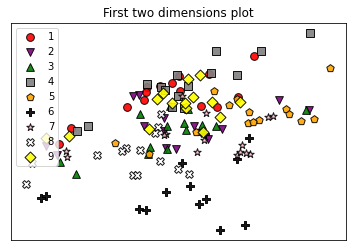

In [107]:
two_dimensions_plot(X, digit)

In [95]:
def apply_dim_reduction(X, num_of_dim, analyze_ratio=False):
    """
    Args: vec: a list of lists. The result of get_vector() function
          num_of_dim: the number of dimensions for the list of lists to be reduced. 
    Returns: trainPCA: a numpy.ndarray which is the result of the PCA reduction of vec with num_of_dim 
    dimensions.
    
    
    """
    pca = PCA(n_components=num_of_dim)
    trainPCA = pca.fit_transform(X)  # mhpws xreiazetai mono fit? Na tsekarw kai ta duo
    
    if analyze_ratio:
        evar = pca.explained_variance_ratio_
        cum_evar = np.cumsum(evar)
        print(cum_evar)
        plt.figure(1, figsize=(5, 5))
        plt.xlabel("Principal Component number")
        plt.ylabel('Cumulative Variance')
        plt.plot(cum_evar, linewidth=2)
        plt.show()
    
    return trainPCA

[0.58491721 0.7050169 ]


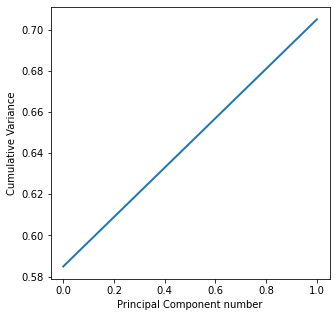

In [96]:
pca = apply_dim_reduction(X, 2, analyze_ratio=True)

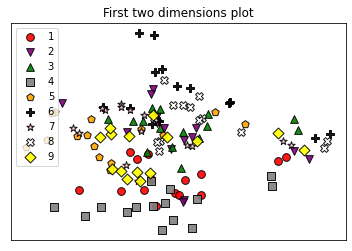

In [98]:
two_dimensions_plot(pca, digit)

In [102]:
def three_dimension_plot(vec, digit, dif_angle=0, n_1=0, n_2=0, analyze_ratio=False):
    """
    Args: vec: a list of lists that respresents the vectorised digits corresponding to the wav files. 
          digit: a list corresponding to the numerical digit of each wav digit. 
    Returns: None. A three dimensional scatter plot of 3-D points that result from the application of PCA
    reduction to the vec list.
    """
    reduction = apply_dim_reduction(vec, 3, analyze_ratio)
        
#     dig = np.array([digits[d[0]] for d in digit])
    color = ['red', 'purple', 'green', 'gray', 'orange', 'black', 'pink', 'white', 'yellow']
    symbol = ['o', 'v', '^', 's', 'p', 'P', '*', 'X', 'D']
    
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(1, 1, 1)
    ax = fig.gca(projection='3d')
    if dif_angle:
        ax.view_init(n_1, n_2)
    x, y, z = [reduction[:, i] for i in range(3)]
    for i in range(1, 10):
        ax.scatter(x[digit==i], y[digit==i], z[digit==i],
                  c = color[i-1], marker=symbol[i-1], label=i,
                  s=60, alpha=0.9, edgecolors='k')

[0.58491721 0.7050169  0.81437482]


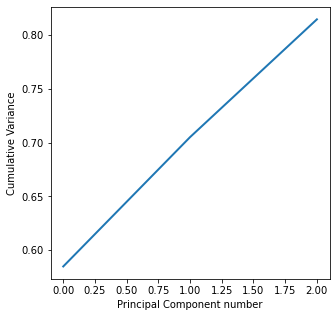

<ipython-input-102-1e02374c15dc>:16: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  ax = fig.gca(projection='3d')
<ipython-input-102-1e02374c15dc>:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.gca(projection='3d')


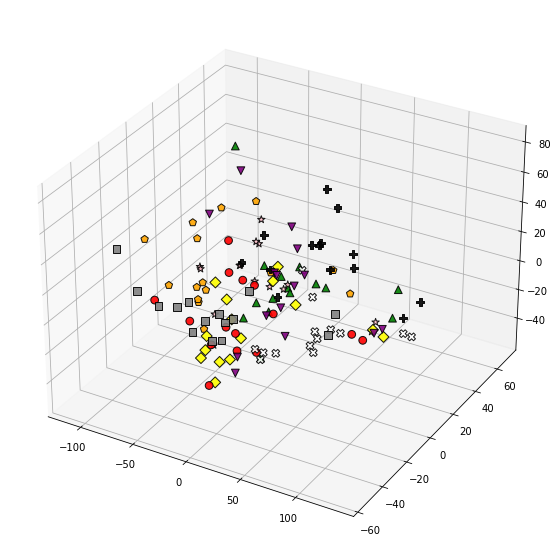

In [103]:
three_dimension_plot(X, digit, analyze_ratio=True)

<ipython-input-102-1e02374c15dc>:16: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  ax = fig.gca(projection='3d')
<ipython-input-102-1e02374c15dc>:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.gca(projection='3d')


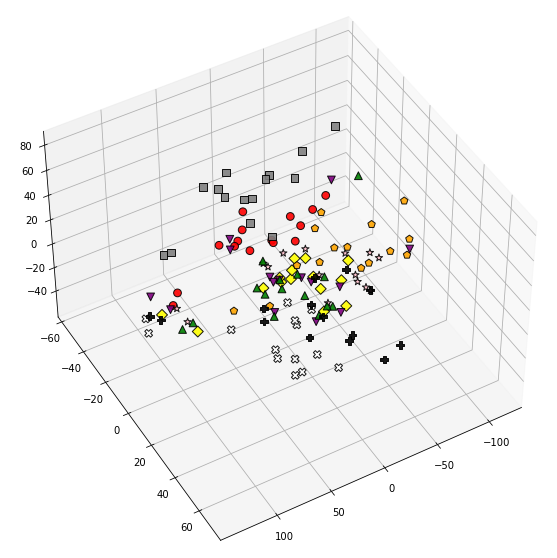

In [109]:
three_dimension_plot(X, digit, 1, 45, 60, analyze_ratio=False)

<ipython-input-102-1e02374c15dc>:16: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  ax = fig.gca(projection='3d')
<ipython-input-102-1e02374c15dc>:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.gca(projection='3d')


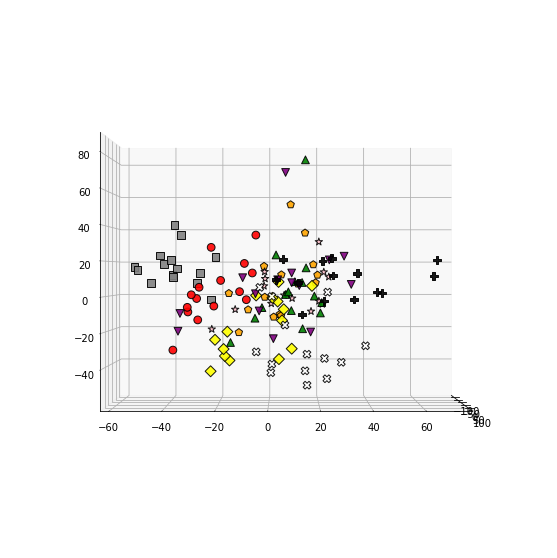

In [110]:
three_dimension_plot(X, digit, 1, 0, 0, analyze_ratio=False)

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, digit, test_size=0.2, random_state=42, stratify=digit)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
X_train_norm = preprocessing.normalize(X_train)
X_val_norm = preprocessing.normalize(X_val)
X_test_norm = preprocessing.normalize(X_test)

In [126]:
class GaussianNB_np(BaseEstimator, ClassifierMixin):  
    """Classify samples based on the Gaussian Naive Bayes"""

    def __init__(self):
        self.X_mean_ = None
        self.X_var_ = None
        self.prior = None
        self.classes = None
        self.n_classes = None


    def fit(self, X, y):
        """
        This should fit classifier. All the "work" should be done here.
        
        Calculates self.X_mean_ and self.X_var_ based on the mean 
        feature values in X for each class. Also, calculates self.prior
        that contains the prior probability of each class.
        
        self.X_mean_ becomes a numpy.ndarray of shape 
        (n_classes, n_features)
        
        self.X_var_ becomes a numpy.ndarray of shape 
        (n_classes, n_features)
        
        self.prior becomes a numpy.array of shape 
        (n_classes)
        
        fit always returns self.
        """

        # Initialize useful variables
        self.classes = np.unique(y)
        train_size, n_features = X.shape
        self.n_classes = len(self.classes)
        self.X_mean_ = np.zeros((self.n_classes, n_features))
        self.X_var_ = np.zeros((self.n_classes, n_features))

        # Compute mean and variance values for each class
        for k, c in enumerate(self.classes):
            idx_i = [i for i in range(train_size) if y[i] == c]
            X_k = np.take(X, idx_i, axis=0)
            self.X_mean_[k, :] = np.mean(X_k, axis=0, keepdims=True)
            self.X_var_[k, :] = np.var(X_k, axis=0, keepdims=True)
        
        # Compute prior probabilities for each class
        self.prior = np.zeros(self.n_classes)
        for k, c in enumerate(self.classes):
            self.prior[k] = np.count_nonzero(y == c) / train_size
        return self
        

    def predict(self, X, smooth=None):
        """
        Make predictions for X based on
        the highest posterior probability
        """

        # Compute likelihood
        like = np.zeros((self.n_classes, len(X)))
        if smooth:
            e = smooth
        else:
            e = 10**(-9)
        for i in range(self.n_classes):
            like[i] = np.prod(1/(np.sqrt(2*np.pi*self.X_var_[i]+ e)) * \
                              np.exp(-0.5*((X - self.X_mean_[i])**2 / (self.X_var_[i] + e))), axis=1)

        return np.argmax(like.T * self.prior, axis=1) + 1
    
    def score(self, X, y, smooth=None):
        """
        Return accuracy score on the predictions
        for X based on ground truth y
        """
        corr = 0
        y_pred = self.predict(X, smooth)
        corr = sum(int(y[i] == y_pred[i]) for i in range(len(y)))
        acc = corr / len(y)
        return acc

In [127]:
# Define a custom scorer
def my_scorer(clf, X, y_true):
    return clf.score(X, y_true)

def find_best_gaussian(X_train, y_train, X_val, y_val):
    gaussNB_np = GaussianNB_np()
    gaussNB_np.fit(X_train, y_train)

    print("Accuracy of custom NumPy GaussianNB classifier")
    print()

    # Predict using default smoothing.
    print("Smoothing 1e-9: " + str(gaussNB_np.score(X_test, y_test)))

    # Predict using 1e-6 smoothing.
    print("Smoothing 1e-6: " + str(gaussNB_np.score(X_test, y_test, smooth=10**(-6))))

    # Predict using 1e-3 smoothing.
    print("Smoothing 1e-3: " + str(gaussNB_np.score(X_test, y_test, smooth=10**(-3))))

    # Predict using 1 smoothing.
    print("Smoothing 1: " + str(gaussNB_np.score(X_test, y_test, smooth=1)))

In [128]:
find_best_gaussian(X_train, y_train, X_val, y_val)

Accuracy of custom NumPy GaussianNB classifier

Smoothing 1e-9: 0.7037037037037037
Smoothing 1e-6: 0.7037037037037037
Smoothing 1e-3: 0.6666666666666666
Smoothing 1: 0.8148148148148148


In [132]:
def check_classifiers(X_train, y_train, X_val, y_val):

    gaussNB = GaussianNB()
    gaussNB.fit(X_train, y_train)

    print("Accuracy of sklearn GaussianNB classifier:", gaussNB.score(X_val, y_val))

    neigh = KNeighborsClassifier(n_neighbors=3)
    neigh.fit(X_train_norm, y_train)
    print("Accuracy of Nearest Neihbors classifier in normalized data:", neigh.score(X_val_norm, y_val))

    svm_poly = SVC(kernel="poly", probability=True) 
    svm_poly.fit(X_train, y_train)
    print("Accuracy of SVM classifier, using poly kernel:", svm_poly.score(X_val, y_val))

    svm_poly = SVC(kernel="poly", probability=True) 
    svm_poly.fit(X_train_norm, y_train)
    print("Accuracy of SVM classifier, using poly kernel in normalized data:", svm_poly.score(X_val_norm, y_val))
    
    
    svm_linear = SVC(kernel="linear", probability=True) 
    svm_linear.fit(X_train, y_train)
    print("Accuracy of SVM classifier, using linear kernel:", svm_linear.score(X_val, y_val))


    svm_linear = SVC(kernel="linear", probability=True) 
    svm_linear.fit(X_val_norm, y_val)
    print("Accuracy of SVM classifier, using linear kernel in normalized data:", svm_linear.score(X_val_norm, y_val))


    svm_rbf = SVC(kernel="rbf", probability=True) 
    svm_rbf.fit(X_train, y_train)
    print("Accuracy of SVM classifier, using rbf kernel:", svm_rbf.score(X_val, y_val))


    svm_rbf = SVC(kernel="rbf", probability=True) 
    svm_rbf.fit(X_train_norm, y_train)
    print("Accuracy of SVM classifier, using rbf kernel in normalized data:", svm_rbf.score(X_val_norm, y_val))


    log_reg = LogisticRegression()
    log_reg.fit(X_train, y_train)
    print("Accuracy of Logistic Regression classifier:", log_reg.score(X_val, y_val))


    log_reg = LogisticRegression()
    log_reg.fit(X_train_norm, y_train)

    print("Accuracy of Logistic Regression classifier in normalized data:", log_reg.score(X_val_norm, y_val))

In [133]:
check_classifiers(X_train, y_train, X_val, y_val)

Accuracy of sklearn GaussianNB classifier: 0.6363636363636364
Accuracy of Nearest Neihbors classifier in normalized data: 0.45454545454545453
Accuracy of SVM classifier, using poly kernel: 0.22727272727272727
Accuracy of SVM classifier, using poly kernel in normalized data: 0.22727272727272727
Accuracy of SVM classifier, using linear kernel: 0.7727272727272727
Accuracy of SVM classifier, using linear kernel in normalized data: 0.45454545454545453
Accuracy of SVM classifier, using rbf kernel: 0.2727272727272727
Accuracy of SVM classifier, using rbf kernel in normalized data: 0.22727272727272727
Accuracy of Logistic Regression classifier: 0.6818181818181818
Accuracy of Logistic Regression classifier in normalized data: 0.2727272727272727


C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, digit, test_size=0.2, random_state=42, stratify=digit)
best_classifier = SVC(kernel="linear", probability=True) 
best_classifier.fit(X_train, y_train)
print("Accuracy of SVM classifier, using linear kernel:", best_classifier.score(X_test, y_test))

Accuracy of SVM classifier, using linear kernel: 0.8518518518518519


In [136]:
def predict_cos():
    f = 40
    X = np.zeros((1000, 10))
    y = np.zeros((1000, 10))

    for i in range(1000):
        A = np.random.rand()*10
        start = np.random.rand() * (40/f)
        time = np.linspace(start, start+0.001*10, num=10)
        X[i] = A*np.sin(2*np.pi*f*time)
        y[i] =  A*np.cos(2*np.pi*f*time)

    fig = plt.figure(figsize=(25,6))
    columns = 9

    samples = [100, 200, 300, 400, 500, 600, 700, 800, 900]

    for i in range(9):
        # Display the randomly selected image in a subplot
        fig.add_subplot(2, columns, i+1)
        plt.plot(np.arange(10), X[samples[i]])

    for i in range(9):
        # Display the randomly selected image in a subplot
        fig.add_subplot(2, columns, i+10)
        plt.plot(np.arange(10), y[samples[i]])


    plt.show()

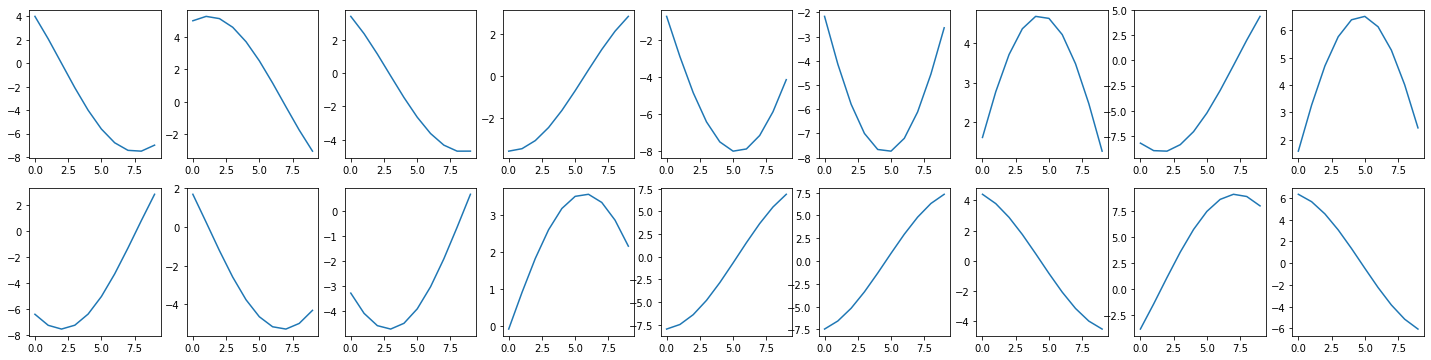

In [137]:
predict_cos()

In [164]:
def parse_free_digits(directory):
    # Parse relevant dataset info
    files = glob(os.path.join(directory, "*.wav"))
    fnames = [f.split(".")[0].split("_") for f in files]
    ids = [f[2] for f in fnames]
    y = [int(f[0]) for f in fnames]
    speakers = [f[1] for f in fnames]
    _, Fs = l.core.load(directory + files[0], sr=None)
    def read_wav(f):
        wav, _ = l.core.load(directory + f, sr=None)

        return wav

    # Read all wavs
    wavs = [read_wav(f) for f in files]

    # Print dataset info
    print("Total wavs: {}. Fs = {} Hz".format(len(wavs), Fs))

    return wavs, Fs, ids, y, speakers

def extract_features(wavs, n_mfcc=13, Fs=8000):
    # Extract MFCCs for all wavs
    window = 30 * Fs // 1000
    step = window // 2
    frames = [
        l.feature.mfcc(
            wav, Fs, n_fft=window, hop_length=window - step, n_mfcc=n_mfcc
        ).T

        for wav in tqdm(wavs, desc="Extracting mfcc features...")
    ]

    print("Feature extraction completed with {} mfccs per frame".format(n_mfcc))

    return frames

def split_free_digits(frames, ids, speakers, labels):
    print("Splitting in train test split using the default dataset split")
    # Split to train-test
    X_train, y_train, spk_train = [], [], []
    X_test, y_test, spk_test = [], [], []
    test_indices = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

    for idx, frame, label, spk in zip(ids, frames, labels, speakers):
        if str(idx) in test_indices:
            X_test.append(frame)
            y_test.append(label)
            spk_test.append(spk)
        else:
            X_train.append(frame)
            y_train.append(label)
            spk_train.append(spk)

    return X_train, X_test, y_train, y_test, spk_train, spk_test

def parser(directory, n_mfcc=6):
    wavs, Fs, ids, y, speakers = parse_free_digits(directory)
    frames = extract_features(wavs, n_mfcc=n_mfcc, Fs=Fs)
    X_train, X_test, y_train, y_test, spk_train, spk_test = split_free_digits(
        frames, ids, speakers, y
    )

    return X_train, X_test, y_train, y_test, spk_train, spk_test

In [ ]:
X_train, X_test, y_train, y_test, _, _ = parser("./recordings/", n_mfcc=13)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=42, stratify=y_train)

In [1]:
class HMM_model:
    """
    This is a class that creates a Hidden Markov Model by using Gaussian Mixture Models. First, we define all
    parameters for the model to be built: The transition matrix, the start and end states, the number of
    states and mixtures and the Gaussian Mixture Models, and then create a Hidden Markov Model estimator with all these
    variables as parameters. Then, we can fit the data that we constructed from the input X_train data, and make a
    prediction based on a new sample. 
    """
    
    def __init__(self, X_train, n_states, n_mixtures):
        self.X = []
        for x in X_train:
            for frame in x:
                self.X.append(frame.flatten()) 
        self.X = np.stack(self.X, axis=0).astype(np.complex128)
        gmm = True if n_mixtures > 1 else False
        dists = [] # list of probability distributions for the HMM states
        for i in range(n_states):
            if gmm:
                a = GeneralMixtureModel.from_samples(MultivariateGaussianDistribution, n_mixtures, X=self.X)
            else:
                a = MultivariateGaussianDistribution.from_samples(self.X)
            dists.append(a)

        trans_mat = np.zeros([n_states, n_states]) # your transition matrix
        if n_states == 1: 
            trans_mat[0, 0] = 1.0
        else:
            for i in range(n_states - 1):
                trans_mat[i, i] = 0.5
                trans_mat[i][i+1] = 0.5
            trans_mat[n_states-1][n_states-1] = 1.
        zeros = [0] * (n_states-1) if n_states>1 else []
        starts = [1.0] # your starting probability matrix
        starts.extend(zeros)
        ends = copy(zeros)
        ends.extend([1.0]) # your ending probability matrix

        self.data = [x.tolist() for x in X_train] 
        # your data: must be a Python list that contains: 2D lists with the sequences (so its dimension would be num_sequences x seq_length x feature_dimension)
        # But be careful, it is not a numpy array, it is a Python list (so each sequence can have different length)

        # Define the GMM-HMM
        self.model = HiddenMarkovModel.from_matrix(trans_mat, dists, starts, ends, state_names=['s{}'.format(i) for i in range(n_states)])
        
        # Fit the model
        self.model.fit(self.data, max_iterations=5)
    
    def return_model(self):
        return self.model

    def predict(self, sample):
        # Predict a sample
        logp, _ = self.model.viterbi(sample) # Run viterbi algorithm and return log-probability
        return logp
    
def predictions_HMM(sample, models):
    """For a given sample, it returns the model that has the highest prediction value."""
    predictions = [model.predict(sample) for model in models]
    max_pred = max(predictions)
    max_model = predictions.index(max_pred)
    return max_model

In [2]:
def call_hmm(X_train, y_train, X_val, y_val):
    """
    This function calculates foe each element of the X_val, the prediction of each model (models correspond to each digit)
    and returns the model with the highest score. It initializes models with different n_states and n_mixtures and calculates
    the accuracy score for every combination of these values. 
    """
    indexes_list = [np.where(y_train==i)[0] for i in np.unique(y_train)]
    training_data = [np.array(X_train)[i.astype(int)] for i in indexes_list]

    n_states = [1,2,3,4]
    n_mixtures = [1,2,3,4,5]
    for states in n_states:
        for mixtures in n_mixtures:
            models = [HMM_model(training_data[i], states, mixtures).return_model() for i in np.unique(y_train)]
            y_pred = [predictions_HMM(X_val[i], models) for i in range(len(y_val))]

            print(f"With n_states = {states} and n_mixtures = {mixtures} The validation accuracy is: {accuracy_score(y_val, y_pred)}")
            
    return models

In [ ]:
call_hmm(X_train, y_train, X_val, y_val)

In [ ]:
def calc_conf_matrix(X_train, y_train, X_test, y_test):
    
    index_list = [np.where(y_train==i)[0] for i in np.unique(y_train)]
    training_data = [np.array(X_train)[i.astype(int)] for i in index_list] 
    models = [HMM_model(training_data[i], 4, 3).return_model() for i in np.unique(y_train)]        

    y_pred = []
    for i in range(len(y_test)):
        y_pred.append(predictions_HMM(X_test[i], models))
    return confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(X_train, y_train, X_test, y_test,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = calc_conf_matrix(X_train, y_train, X_test, y_test)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
plot_confusion_matrix(X_train, X_test, y_test, range(10))

In [139]:
class FrameLevelDataset(Dataset):
    def __init__(self, feats, labels):
        """
            feats: Python list of numpy arrays that contain the sequence features.
                   Each element of this list is a numpy array of shape seq_length x feature_dimension
            labels: Python list that contains the label for each sequence (each label must be an integer)
        """
        self.lengths =  [len(example) for example in feats] 

        self.feats = self.zero_pad_and_stack(feats)
        if isinstance(labels, (list, tuple)):
            self.labels = np.array(labels).astype('int64')

    def zero_pad_and_stack(self, x):
        """
            This function performs zero padding on a list of features and forms them into a numpy 3D array
            returns
                padded: a 3D numpy array of shape num_sequences x max_sequence_length x feature_dimension
        """
        padded = []
        # --------------- Insert your code here ---------------- #
        max_length = max(self.lengths)
        padded = np.array([np.pad(example, ((0, max_length-len(example)), (0, 0))) for example in x])

        return padded

    def __getitem__(self, item):
        return self.feats[item], self.labels[item], self.lengths[item]

    def __len__(self):
        return len(self.feats)

In [156]:
class FrameLevelDataset(Dataset):
    def __init__(self, feats, labels):
        """
            feats: Python list of numpy arrays that contain the sequence features.
                   Each element of this list is a numpy array of shape seq_length x feature_dimension
            labels: Python list that contains the label for each sequence (each label must be an integer)
        """
        self.lengths =  [len(example) for example in feats] 

        self.feats = self.zero_pad_and_stack(feats)
        if isinstance(labels, (list, tuple)):
            self.labels = np.array(labels).astype('int64')

    def zero_pad_and_stack(self, x):
        """
            This function performs zero padding on a list of features and forms them into a numpy 3D array
            returns
                padded: a 3D numpy array of shape num_sequences x max_sequence_length x feature_dimension
        """
        padded = []
        # --------------- Insert your code here ---------------- #
        max_length = max(self.lengths)
        padded = np.array([np.pad(example, ((0, max_length-len(example)), (0, 0))) for example in x])

        return padded

    def __getitem__(self, item):
        return self.feats[item], self.labels[item], self.lengths[item]

    def __len__(self):
        return len(self.feats)


In [ ]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

train_set = FrameLevelDataset(X_tr, y_tr)
val_set = FrameLevelDataset(X_val, y_val)
test_set = FrameLevelDataset(X_test, y_test)

BATCH_SIZE = 64

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=8)

val_loader = DataLoader(val_set, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=8)

test_loader = DataLoader(test_set, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=8)

In [ ]:
class BasicLSTM(nn.Module):
    def __init__(self, input_dim, rnn_size, output_dim, num_layers, bidirectional=False, dropout=0):
        super(BasicLSTM, self).__init__()
        self.bidirectional = bidirectional
        self.rnn_size = rnn_size
        self.feature_size = rnn_size * 2 if self.bidirectional else rnn_size
        self.num_layers = num_layers
        self.dropout = dropout
        
        # --------------- Insert your code here ---------------- #
        # Initialize the LSTM, Dropout, Output layers
        
        self.lstm = nn.LSTM(input_dim, self.rnn_size, self.num_layers, bidirectional=self.bidirectional, batch_first=True, dropout=self.dropout)
        self.linear = nn.Linear(self.feature_size, output_dim)

    def forward(self, x, lengths):
        """ 
            x : 3D numpy array of dimension N x L x D
                N: batch index
                L: sequence index
                D: feature index

            lengths: N x 1
         """
        
        # --------------- Insert your code here ---------------- #
        # Obtain the model's device ID
        DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # You must have all of the outputs of the LSTM, but you need only the last one (that does not exceed the sequence length)
        # To get it use the last_timestep method
        # Then pass it through the remaining network
        
        if self.bidirectional:
            h0 = torch.zeros(self.num_layers*2, x.size(0), self.rnn_size).to(DEVICE)
            c0 = torch.zeros(self.num_layers*2, x.size(0), self.rnn_size).to(DEVICE)
        else:
            h0 = torch.zeros(self.num_layers, x.size(0), self.rnn_size).to(DEVICE)
            c0 = torch.zeros(self.num_layers, x.size(0), self.rnn_size).to(DEVICE)
            
        # Forward propagate LSTM
        lstm_out, _ = self.lstm(x, (h0, c0))
        # Forward propagate Linear
        last_outputs = self.linear(self.last_timestep(lstm_out, lengths, self.bidirectional))
        return last_outputs

    def last_timestep(self, outputs, lengths, bidirectional=False):
        """
            Returns the last output of the LSTM taking into account the zero padding
        """
        if bidirectional:
            forward, backward = self.split_directions(outputs)
            last_forward = self.last_by_index(forward, lengths)
            last_backward = backward[:, 0, :]
            # Concatenate and return - maybe add more functionalities like average
            return torch.cat((last_forward, last_backward), dim=-1)

        else:
            return self.last_by_index(outputs, lengths)

    @staticmethod
    def split_directions(outputs):
        direction_size = int(outputs.size(-1) / 2)
        forward = outputs[:, :, :direction_size]
        backward = outputs[:, :, direction_size:]
        return forward, backward

    @staticmethod
    def last_by_index(outputs, lengths):
        # Obtain the model's device ID
        DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Index of the last output for each sequence.
        idx = (lengths - 1).view(-1, 1).expand(outputs.size(0),
                                               outputs.size(2)).unsqueeze(1).to(DEVICE)
        return outputs.gather(1, idx).squeeze()

In [ ]:
def train_dataset(_epoch, dataloader, model, loss_function, optimizer):
    # IMPORTANT: switch to train mode
    # Εnable regularization layers, such as Dropout
    model.train()
    running_loss = 0.0

    # Οbtain the model's device ID
    device = next(model.parameters()).device

    for index, batch in enumerate(dataloader, 1):
        # Get the inputs (batch)
        inputs, labels, lengths = batch

        # Move the batch tensors to the right device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Step 1 - zero the gradients
        # Remember that PyTorch accumulates gradients.
        # We need to clear them out before each batch!
        optimizer.zero_grad()

        # Step 2 - forward pass: y' = model(x)
        y_preds = model(inputs, lengths)

        # Step 3 - compute loss: L = loss_function(y, y')
        loss = loss_function(y_preds, labels)

        # Step 4 - backward pass: compute gradient wrt model parameters
        loss.backward()

        # Step 5 - update weights
        optimizer.step()

        # Accumulate loss in a variable.
        running_loss += loss.data.item()

    return running_loss / index

In [ ]:
def eval_dataset(dataloader, model, loss_function):
    # IMPORTANT: switch to eval mode
    # Disable regularization layers, such as Dropout
    model.eval()
    running_loss = 0.0

    y_pred = []  # the predicted labels
    y = []  # the gold labels

    # Obtain the model's device ID
    device = next(model.parameters()).device

    # IMPORTANT: in evaluation mode, we don't want to keep the gradients
    # so we do everything under torch.no_grad()

    with torch.no_grad():
        for index, batch in enumerate(dataloader, 1):
            # Get the inputs (batch)
            inputs, labels, lengths = batch

            # Step 1 - move the batch tensors to the right device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Step 2 - forward pass: y' = model(x)
            y_preds = model(inputs, lengths)  # EX9

            # Step 3 - compute loss: L = loss_function(y, y')
            # We compute the loss only for inspection (compare train/test loss)
            # because we do not actually backpropagate in test time
            loss = loss_function(y_preds, labels)

            # Step 4 - make predictions (class = argmax of posteriors)
            y_preds_arg = torch.argmax(y_preds, dim=1)

            # Step 5 - collect the predictions, gold labels and batch loss
            y_pred.append(y_preds_arg.cpu().numpy())
            y.append(labels.cpu().numpy())

            # Accumulate loss in a variable
            running_loss += loss.data.item()
    return running_loss / index, (y, y_pred)

In [ ]:
_, num_mfcc = X_train[0].shape

print("Number of MFCCs: %d" %num_mfcc)

RNN_SIZE = 32
EPOCHS = 50

model = BasicLSTM(num_mfcc, RNN_SIZE, 10, 1)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
total_train_loss = [] 

for epoch in range(EPOCHS):
    # Train the model for one epoch
    train_dataset(epoch, train_loader, model, loss_function, optimizer)
    # Evaluate the performance of the model, on train set
    train_loss, _ = eval_dataset(train_loader, model, loss_function)
    print(train_loss)
    total_train_loss.append(train_loss)

In [ ]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(total_train_loss)

val_loss, (y, y_pred) = eval_dataset(val_loader, model, loss_function)
print('Loss: %f' %val_loss)
y_conc = np.concatenate( y, axis=0 )
y_pred_conc = np.concatenate( y_pred, axis=0 )
print('Accuracy: %f' %accuracy_score(y_conc, y_pred_conc))

In [ ]:
RNN_SIZE = 32
EPOCHS = 50

model = BasicLSTM(num_mfcc, RNN_SIZE, 10, 1)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
total_train_loss = []
total_val_loss = []

for i in range(EPOCHS):
    # Train the model for one epoch
    train_dataset(epoch, train_loader, model, loss_function, optimizer)
    
    # Evaluate the performance of the model, on both data sets
    train_loss, _ = eval_dataset(train_loader, model, loss_function)

    val_loss, _ = eval_dataset(val_loader, model, loss_function)
    
    print("Train: %f" %train_loss)
    print("Validation: %f" %val_loss)
    total_train_loss.append(train_loss)
    total_val_loss.append(val_loss)
    print()

In [ ]:
x = np.arange(EPOCHS)
plt.plot(x, total_train_loss, label = "train loss")
plt.plot(x, total_val_loss, label = "val loss")
plt.xlabel('epochs')
# Set the y axis label of the current axis.
plt.ylabel('loss')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [ ]:
RNN_SIZE = 32
EPOCHS = 50

model = BasicLSTM(num_mfcc, RNN_SIZE, 10, 2, dropout=0.3)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

total_train_reg_loss = []
total_val_reg_loss = []

for i in range(EPOCHS):
    # Train the model for one epoch
    train_dataset(epoch, train_loader, model, loss_function, optimizer)
    
    # Evaluate the performance of the model, on both data sets
    train_loss, _ = eval_dataset(train_loader, model, loss_function)

    val_loss, _ = eval_dataset(val_loader, model, loss_function)
    
    print("Train: %f" %train_loss)
    print("Validation: %f" %val_loss)
    total_train_reg_loss.append(train_loss)
    total_val_reg_loss.append(val_loss)
    print()


In [ ]:
x = np.arange(EPOCHS)
plt.plot(x, total_train_loss, label = "train loss")
plt.plot(x, total_val_loss, label = "val loss")
plt.plot(x, total_train_reg_loss, label = "train loss with normalization and dropout")
plt.plot(x, total_val_reg_loss, label = "val loss with normalization and dropout")
plt.xlabel('epochs')
# Set the y axis label of the current axis.
plt.ylabel('loss')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [ ]:
val_loss, (y, y_pred) = eval_dataset(val_loader, model, loss_function)
print('Loss: %f' %val_loss)
y_conc = np.concatenate( y, axis=0 )
y_pred_conc = np.concatenate( y_pred, axis=0 )
print('Accuracy: %f' %accuracy_score(y_conc, y_pred_conc))

In [ ]:
RNN_SIZE = 32
EPOCHS = 150

model = BasicLSTM(num_mfcc, RNN_SIZE, 10, 2, dropout=0.3)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
n_epochs_stop = 10
min_val_loss = 1000
epochs_no_improve = 0

total_train_reg_loss_early = []
total_val_reg_loss_early = []

for epoch in range(EPOCHS):
    # Train the model for one epoch
    train_dataset(epoch, train_loader, model, loss_function, optimizer)
    
    # Evaluate the performance of the model, on both data sets
    train_loss, _ = eval_dataset(train_loader, model, loss_function)

    val_loss, _ = eval_dataset(val_loader, model, loss_function)
    
    if val_loss < min_val_loss:
        # Save the model
        torch.save(model, "./model")
        epochs_no_improve = 0
        min_val_loss = val_loss
    else:
        epochs_no_improve += 1
            
    if epochs_no_improve == n_epochs_stop:
        print('Early stopping!')
        break

    print("Train: %f" %train_loss)
    print("Validation: %f" %val_loss)
    total_train_reg_loss_early.append(train_loss)
    total_val_reg_loss_early.append(val_loss)
    print()

In [ ]:
x = np.arange(epoch)
plt.plot(x, total_train_reg_loss_early, label = "train loss early stopping")
plt.plot(x, total_val_reg_loss_early, label = "val loss early stopping")
plt.xlabel('epochs')
# Set the y axis label of the current axis.
plt.ylabel('loss')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [ ]:
val_loss, (y, y_pred) = eval_dataset(val_loader, model, loss_function)
print('Loss: %f' %val_loss)
y_conc = np.concatenate( y, axis=0 )
y_pred_conc = np.concatenate( y_pred, axis=0 )
print('Accuracy: %f' %accuracy_score(y_conc, y_pred_conc))

In [ ]:
RNN_SIZE = 32
EPOCHS = 150

model = BasicLSTM(num_mfcc, RNN_SIZE, 10, 2, dropout=0.3, bidirectional=True)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
n_epochs_stop = 10
min_val_loss = 1000
epochs_no_improve = 0

total_train_bid = []
total_val_bid = []

for epoch in range(EPOCHS):
    # Train the model for one epoch
    train_dataset(epoch, train_loader, model, loss_function, optimizer)
    
    # Evaluate the performance of the model, on both data sets
    train_loss, _ = eval_dataset(train_loader, model, loss_function)

    val_loss, _ = eval_dataset(val_loader, model, loss_function)
    
    if val_loss < min_val_loss:
        # Save the model
        torch.save(model, "./model_bid")
        epochs_no_improve = 0
        min_val_loss = val_loss
    else:
        epochs_no_improve += 1
            
    if epochs_no_improve == n_epochs_stop:
        print('Early stopping!')
        break

    print("Train: %f" %train_loss)
    print("Validation: %f" %val_loss)
    total_train_bid.append(train_loss)
    total_val_bid.append(val_loss)
    print()

In [ ]:
x = np.arange(epoch)
plt.plot(x, total_train_bid, label = "train loss")
plt.plot(x, total_val_bid, label = "val loss")
plt.xlabel('epochs')
# Set the y axis label of the current axis.
plt.ylabel('loss')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [ ]:
val_loss, (y, y_pred) = eval_dataset(val_loader, model, loss_function)
print('Loss: %f' %val_loss)
y_conc = np.concatenate( y, axis=0 )
y_pred_conc = np.concatenate( y_pred, axis=0 )
print('Accuracy: %f' %accuracy_score(y_conc, y_pred_conc))

In [ ]:
class BasicLSTM_packed(nn.Module):
    def __init__(self, input_dim, rnn_size, output_dim, num_layers, bidirectional=False, dropout=0):
        super(BasicLSTM_packed, self).__init__()
        self.bidirectional = bidirectional
        self.rnn_size = rnn_size
        self.feature_size = rnn_size * 2 if self.bidirectional else rnn_size
        self.num_layers = num_layers
        self.dropout = dropout

        # --------------- Insert your code here ---------------- #
        # Initialize the LSTM, Dropout, Output layers
        
        self.lstm = nn.LSTM(input_dim, self.rnn_size, self.num_layers, bidirectional=self.bidirectional, batch_first=True, dropout=self.dropout)
        self.linear = nn.Linear(self.feature_size, output_dim)

    def forward(self, x, lengths):
        """ 
            x : 3D numpy array of dimension N x L x D
                N: batch index
                L: sequence index
                D: feature index

            lengths: N x 1
         """
        
        # --------------- Insert your code here ---------------- #
        # Obtain the model's device ID
        DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # You must have all of the outputs of the LSTM, but you need only the last one (that does not exceed the sequence length)
        # To get it use the last_timestep method
        # Then pass it through the remaining network
        
        if self.bidirectional:
            h0 = torch.zeros(self.num_layers*2, x.size(0), self.rnn_size).to(DEVICE)
            c0 = torch.zeros(self.num_layers*2, x.size(0), self.rnn_size).to(DEVICE)
        else:
            h0 = torch.zeros(self.num_layers, x.size(0), self.rnn_size).to(DEVICE)
            c0 = torch.zeros(self.num_layers, x.size(0), self.rnn_size).to(DEVICE)
            
        # Sort the input and lengths as the descending order
        lengths, perm_index = lengths.sort(0, descending=True)
        x = x[perm_index]
        

        packed_x = pack_padded_sequence(x, list(lengths.data), batch_first=True)
            
        # Forward propagate LSTM
        lstm_out, _ = self.lstm(packed_x, (h0, c0))
        
        lstm_out = pad_packed_sequence(lstm_out, batch_first=True)[0]
        
        _, unperm_index = perm_index.sort(0)
        lstm_out = lstm_out[unperm_index]
        
        # Forward propagate Linear
        last_outputs = self.linear(self.last_timestep(lstm_out, lengths, self.bidirectional))
        return last_outputs

    def last_timestep(self, outputs, lengths, bidirectional=False):
        """
            Returns the last output of the LSTM taking into account the zero padding
        """
        if bidirectional:
            forward, backward = self.split_directions(outputs)
            last_forward = self.last_by_index(forward, lengths)
            last_backward = backward[:, 0, :]
            # Concatenate and return - maybe add more functionalities like average
            return torch.cat((last_forward, last_backward), dim=-1)

        else:
            return self.last_by_index(outputs, lengths)

    @staticmethod
    def split_directions(outputs):
        direction_size = int(outputs.size(-1) / 2)
        forward = outputs[:, :, :direction_size]
        backward = outputs[:, :, direction_size:]
        return forward, backward

    @staticmethod
    def last_by_index(outputs, lengths):
        # Obtain the model's device ID
        DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Index of the last output for each sequence.
        idx = (lengths - 1).view(-1, 1).expand(outputs.size(0),
                                               outputs.size(2)).unsqueeze(1).to(DEVICE)
        return outputs.gather(1, idx).squeeze()

In [ ]:
RNN_SIZE = 32
EPOCHS = 150

model = BasicLSTM_packed(num_mfcc, RNN_SIZE, 10, 2, dropout=0.3, bidirectional=True)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
n_epochs_stop = 10
min_val_loss = 1000
epochs_no_improve = 0

total_train_bid_packed = []
total_val_bid_packed = []

for epoch in range(EPOCHS):
    # Train the model for one epoch
    train_dataset(epoch, train_loader, model, loss_function, optimizer)
    
    # Evaluate the performance of the model, on both data sets
    train_loss, _ = eval_dataset(train_loader, model, loss_function)

    val_loss, _ = eval_dataset(val_loader, model, loss_function)
    
    if val_loss < min_val_loss:
        # Save the model
        torch.save(model, "./model_bid_packed")
        epochs_no_improve = 0
        min_val_loss = val_loss
    else:
        epochs_no_improve += 1
            
    if epochs_no_improve == n_epochs_stop:
        print('Early stopping!')
        break

    print("Train: %f" %train_loss)
    print("Validation: %f" %val_loss)
    total_train_bid_packed.append(train_loss)
    total_val_bid_packed.append(val_loss)
    print()

In [ ]:
x = np.arange(epoch)
plt.plot(x, total_train_bid_packed, label = "train loss packed method")
plt.plot(x, total_val_bid_packed, label = "val loss packed method")
plt.xlabel('epochs')
# Set the y axis label of the current axis.
plt.ylabel('loss')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [ ]:
val_loss, (y, y_pred) = eval_dataset(val_loader, model, loss_function)
print('Loss: %f' %val_loss)
y_conc = np.concatenate( y, axis=0 )
y_pred_conc = np.concatenate( y_pred, axis=0 )
print('Accuracy: %f' %accuracy_score(y_conc, y_pred_conc))